**Spatial Research**

# Key Results

- HH index is added into OLS 实验
- 

## Methodology



# HH index

HH index can be treated to measure the tech industry diversity. For calculate industry mix level, `primary_sic_code` will be utilised to do a `group by` operation

According to [EDA analysis](https://zeqiang.fun/CASA0012-Dissertation/jupyterlab/EDA.html), It can be found that most of tech firms are clustered in the England. In the next step, this research will focus more on the England country. `ctry` can be a filter to get the `country == 'England'` tech firms information

Method: HIH index can be calculate in the below function 

$$ Herfindahl\ Index_{i,t} = \sum_1^k (\frac{Tech\ Firms_{i,t,k}}{Total\ Tech\ Firms_{i,t}})^2 $$

Where the HH index will be calculated from industry `1` to `k`; location `i` and year `t` are also concerned. This formula means, in year `t` and location `i`, the number of tech firms which belong to industry `k` divide that of the total firms. This index can measure how diverse the tech cluster are.

In [24]:
#read data
import sys
import pandas as pd
PATH = sys.path[0]
df = pd.read_csv(PATH + "/Dataset/fame_OC_tech_firm.csv",low_memory = False)
dfp = df.drop({"Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1","is_tech"},axis=1)

# data select
# dfp means df is processed
dfp = dfp[["registered_number","diss_year","birth_year","primary_uk_sic_2007","ttwa","ctry"]]

# dna means drop na value
dfp_dna = dfp.dropna(subset=["birth_year","ttwa","ctry"]).reset_index(drop=True)

# introduce the ttwa to filter england firms
dfp_dna = dfp_dna[dfp_dna.ctry=="E92000001"]
dfp_dna = dfp_dna[dfp_dna.birth_year >= 1998]

#export to the excel to do operation
df_excel = dfp_dna.copy() 
df_excel.to_excel(PATH + "/tech_cluster_ttwa_in_England.xlsx")

In [38]:
# process the .csv file
df_csv = pd.read_csv(PATH + "/MySQL/tech_cluster_ttwa_in_England.csv")
df_csv = df_csv.fillna(0)
df_csv.to_csv(PATH + "/MySQL/tech_cluster_ttwa_in_England_fillna.csv")

After pivot operation in the Excel, the dataset is also imported into MySQL to calculate the HH index.

The method/code is presented below:

```sql
CREATE TABLE tech_cluster_hh
SELECT t2.ttwa, t2.birth_year, sum(t2.sub_hh) as hh
FROM (SELECT t0.ttwa, 
            t0.birth_year,
            t0.primary_uk_sic_2007, 
            power(count(t0.registered_number)/t1.year_total,2) as sub_hh
            FROM `casa-dissertation`.tech_cluster_ttwa_in_England_year_98218_sic as t0,
                (SELECT ttwa, 
                        birth_year,  
                        count(registered_number) as year_total 
                        FROM `casa-dissertation`.tech_cluster_ttwa_in_England_year_98218_sic
                        GROUP BY ttwa, birth_year) as t1
            WHERE t0.ttwa = t1.ttwa and t0.birth_year = t1.birth_year
            GROUP BY t0.ttwa, t0.birth_year, t0.primary_uk_sic_2007 ) as t2
GROUP BY t2.ttwa, t2.birth_year
```

Then import this processed `.csv` to get HH index from two scale (location&year, location)

【HH index in TTWA and Year】

In [41]:
# means HH index in year t and location i
df_hh_i_t = pd.read_csv(PATH + "/MySQL/tech_cluster_hh.csv",";")
df_hh_i_t.head()

,ttwa,birth_year,hh
0,E30000266,2016,0.131154
1,E30000229,2016,0.097108
2,E30000234,2016,0.082406
3,E30000247,2016,0.066072
4,E30000239,2016,0.076159


【HH index in TTWA】

In [42]:
# means HH index in year t and location i
df_hh_i = pd.read_csv(PATH + "/MySQL/tech_cluster_hh_ttwa.csv",",")
df_hh_i.head()

,ttwa,hh
0,E30000266,0.105359
1,E30000229,0.087589
2,E30000234,0.070735
3,E30000247,0.063472
4,E30000239,0.058811


# Map Visualisation

import the geo dataset for ttwa in the England

In [13]:
# spatial map prepare
# read spatial data
import geopandas as gpd
g_ttwa = gpd.read_file(PATH + "/Dataset/Spatial/Travel_to_Work_Areas__December_2011__Generalised_Clipped_Boundaries_in_United_Kingdom.geojson")

According to [CSDN](https://blog.csdn.net/weixin_44122191/article/details/109008193), I ustilise the below method to filter string

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/geopandas/geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


<AxesSubplot:>

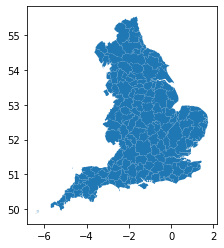

In [44]:
# print(g_ttwa.TTWA11CD.value_counts())
# input
df_tmp = g_ttwa.copy()
df_tmp.col_tmp = g_ttwa.TTWA11CD
letter_str_1 = "E"
# letter_str_2 = "K"

mask = [True if i[0]==letter_str_1 else False for i in df_tmp.col_tmp]

# output
g_ttwa_England = df_tmp[mask]
# print(g_ttwa_England.TTWA11CD.value_counts())
g_ttwa_England.plot()

In [48]:
# inspect the data
g_ttwa_England.head(1)

,OBJECTID,TTWA11CD,TTWA11NM,Shape__Area,Shape__Length,geometry
0,1,E30000004,Barnsley,3.424992e+08,129308.31911,"POLYGON ((-1.44681 53.61282, -1.44475 53.61061..."


## Industry Mix: HHI

In [47]:
# inspect the data
df_hh_i.head(1)

,ttwa,hh
0,E30000266,0.105359


In [51]:
# merge with `df_hh_i`

df_ttwa_hh_mg = pd.merge(g_ttwa,df_hh_i, left_on='TTWA11CD',right_on="ttwa",how = "inner").reset_index(drop=True)
df_ttwa_hh_mg.head()

,OBJECTID,TTWA11CD,TTWA11NM,Shape__Area,Shape__Length,geometry,ttwa,hh
0,1,E30000004,Barnsley,3.424992e+08,129308.319110,"POLYGON ((-1.44681 53.61282, -1.44475 53.61061...",E30000004,0.045157
1,2,E30000018,Bradford,3.438902e+08,119605.015955,"POLYGON ((-1.94399 53.95619, -1.94161 53.95252...",E30000018,0.081738
2,3,E30000029,Halifax,3.639425e+08,105182.259501,"POLYGON ((-2.03257 53.81023, -2.03138 53.80902...",E30000029,0.067777
3,4,E30000039,Skipton,1.178893e+09,197077.350855,"POLYGON ((-2.30733 54.25008, -2.30511 54.24934...",E30000039,0.062993
4,5,E30000046,Dorchester and Weymouth,7.200201e+08,226091.682220,"MULTIPOLYGON (((-2.22501 50.61646, -2.22520 50...",E30000046,0.059792


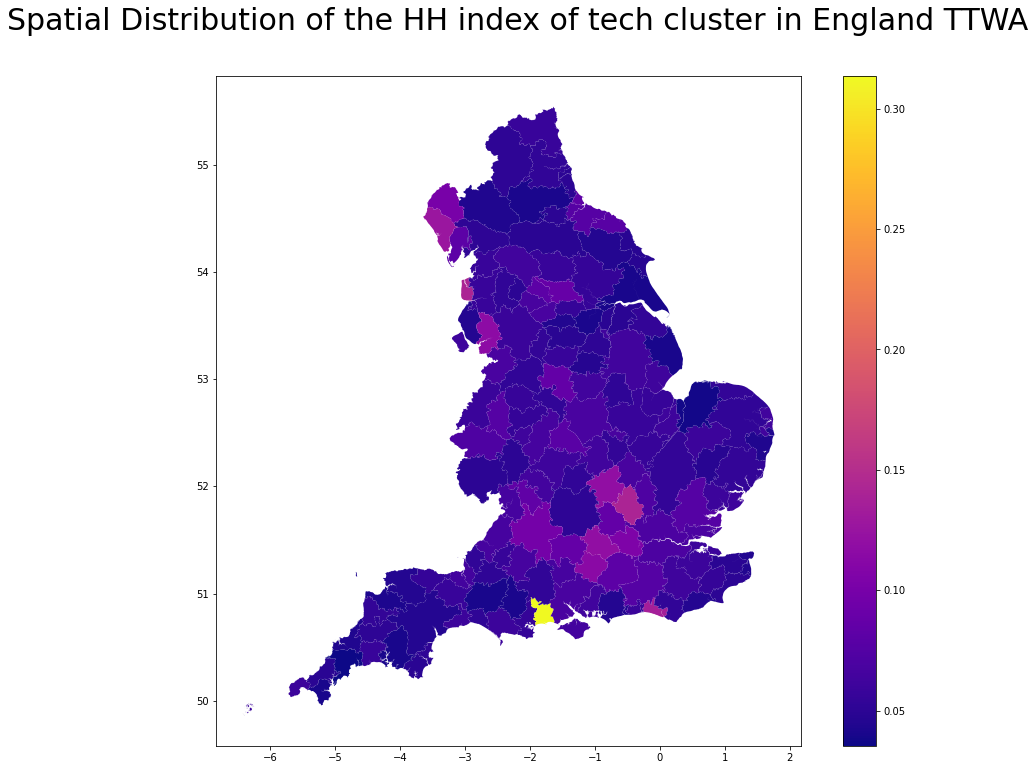

In [106]:
title_text = "Spatial Distribution of the HH index of tech cluster in England TTWA"

df_left = g_ttwa
left_key = 'TTWA11CD'

df_right = df_hh_i
right_key = "ttwa"

map_attribute = "hh"


# merge
df_mg = pd.merge(df_left,df_right, left_on = left_key,right_on=right_key,how = "inner").reset_index(drop=True)
# map
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f1 = plt.figure()
f1.set_size_inches(15,12)

ax1 = f1.add_subplot()
df_mg.plot(column = map_attribute, legend=True, cmap='plasma',linestyle='solid', ax=ax1)
# df_ttwa_hh_mg.plot(column='count', legend=True, cmap='plasma',figsize=(180,60),ax=ax1)

f1.subplots_adjust(top=0.9)
f1.suptitle(title_text, x=0.01, size=30, **tfont)
f1.savefig(PATH + "/Img/" + title_text + ".png", dpi=300)

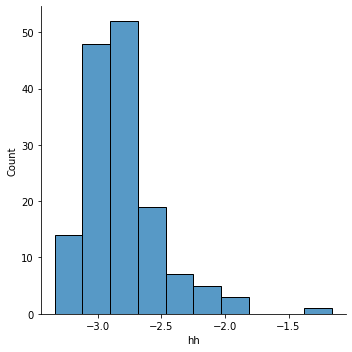

In [84]:
import seaborn as sns
import numpy as np
df = df_ttwa_hh_mg.copy()
df.hh = np.log(df.hh)
attributes = "hh"
sns.displot(df, x=attributes,bins=10)

## Dynamics: Entry Rate

In [85]:
# read data

# means Entry Rate in location i
df_EnR_i = pd.read_excel(PATH + "/Excel/tech_cluster_ttwa_in_England_EnR.xlsx", sheet_name = "ttwa_EnR")
df_EnR_i.head()

,ttwa,2018,total,Entry_Rate
0,E30000004,93,749,0.124166
1,E30000018,334,1771,0.188594
2,E30000029,132,945,0.139683
3,E30000039,23,225,0.102222
4,E30000046,66,623,0.105939


The template method is writen below

Text(0.01, 0.98, 'Spatial Distribution of the entry rate index of tech cluster in England TTWA')

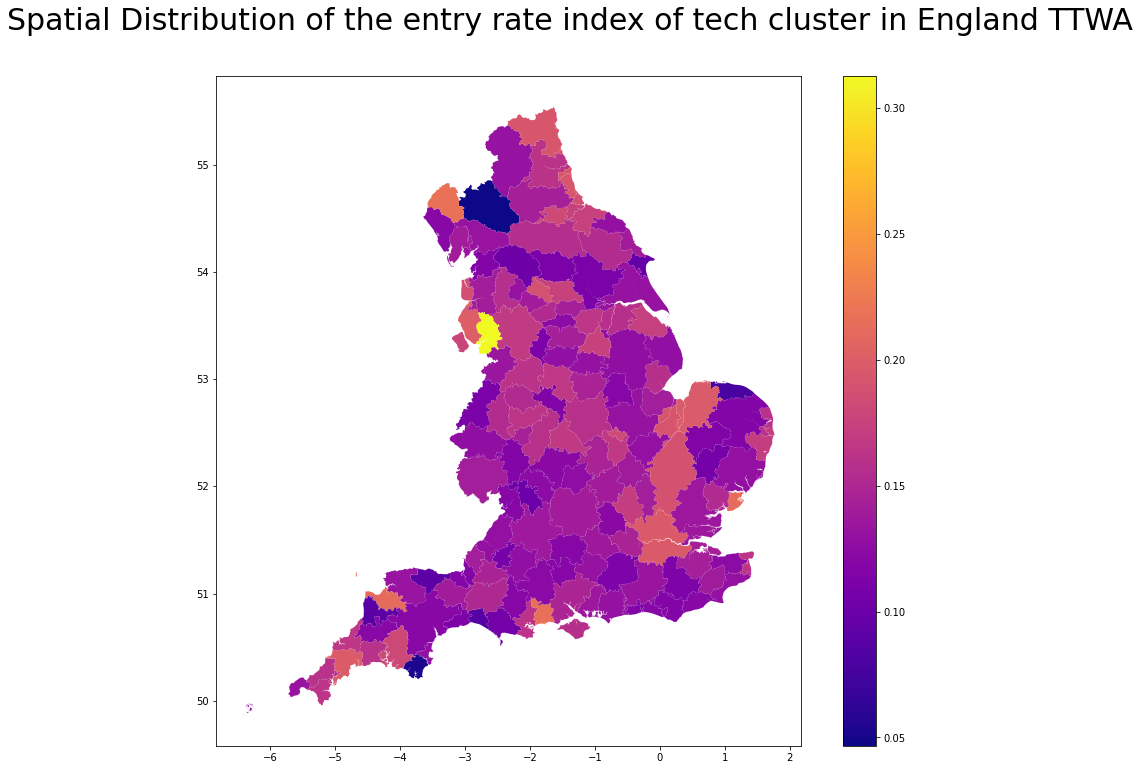

In [104]:
title_text = "Spatial Distribution of the entry rate index of tech cluster in England TTWA"

df_left = g_ttwa
left_key = 'TTWA11CD'

df_right = df_EnR_i
right_key = "ttwa"

map_attribute = "Entry_Rate"


# merge
df_mg = pd.merge(df_left,df_right, left_on = left_key,right_on=right_key,how = "inner").reset_index(drop=True)

# map
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f1 = plt.figure()
f1.set_size_inches(15,12)

ax1 = f1.add_subplot()
df_mg.plot(column = map_attribute, legend=True, cmap='plasma', linestyle='solid', ax=ax1)
# df_ttwa_hh_mg.plot(column='count', legend=True, cmap='plasma',figsize=(180,60),ax=ax1)

f1.subplots_adjust(top=0.9)
f1.suptitle(title_text, x=0.01, size=30, **tfont)
# f1.savefig(PATH + "/Img/" + title_text + ".png", dpi=300)

## Industry Mix V.S. Dynamics

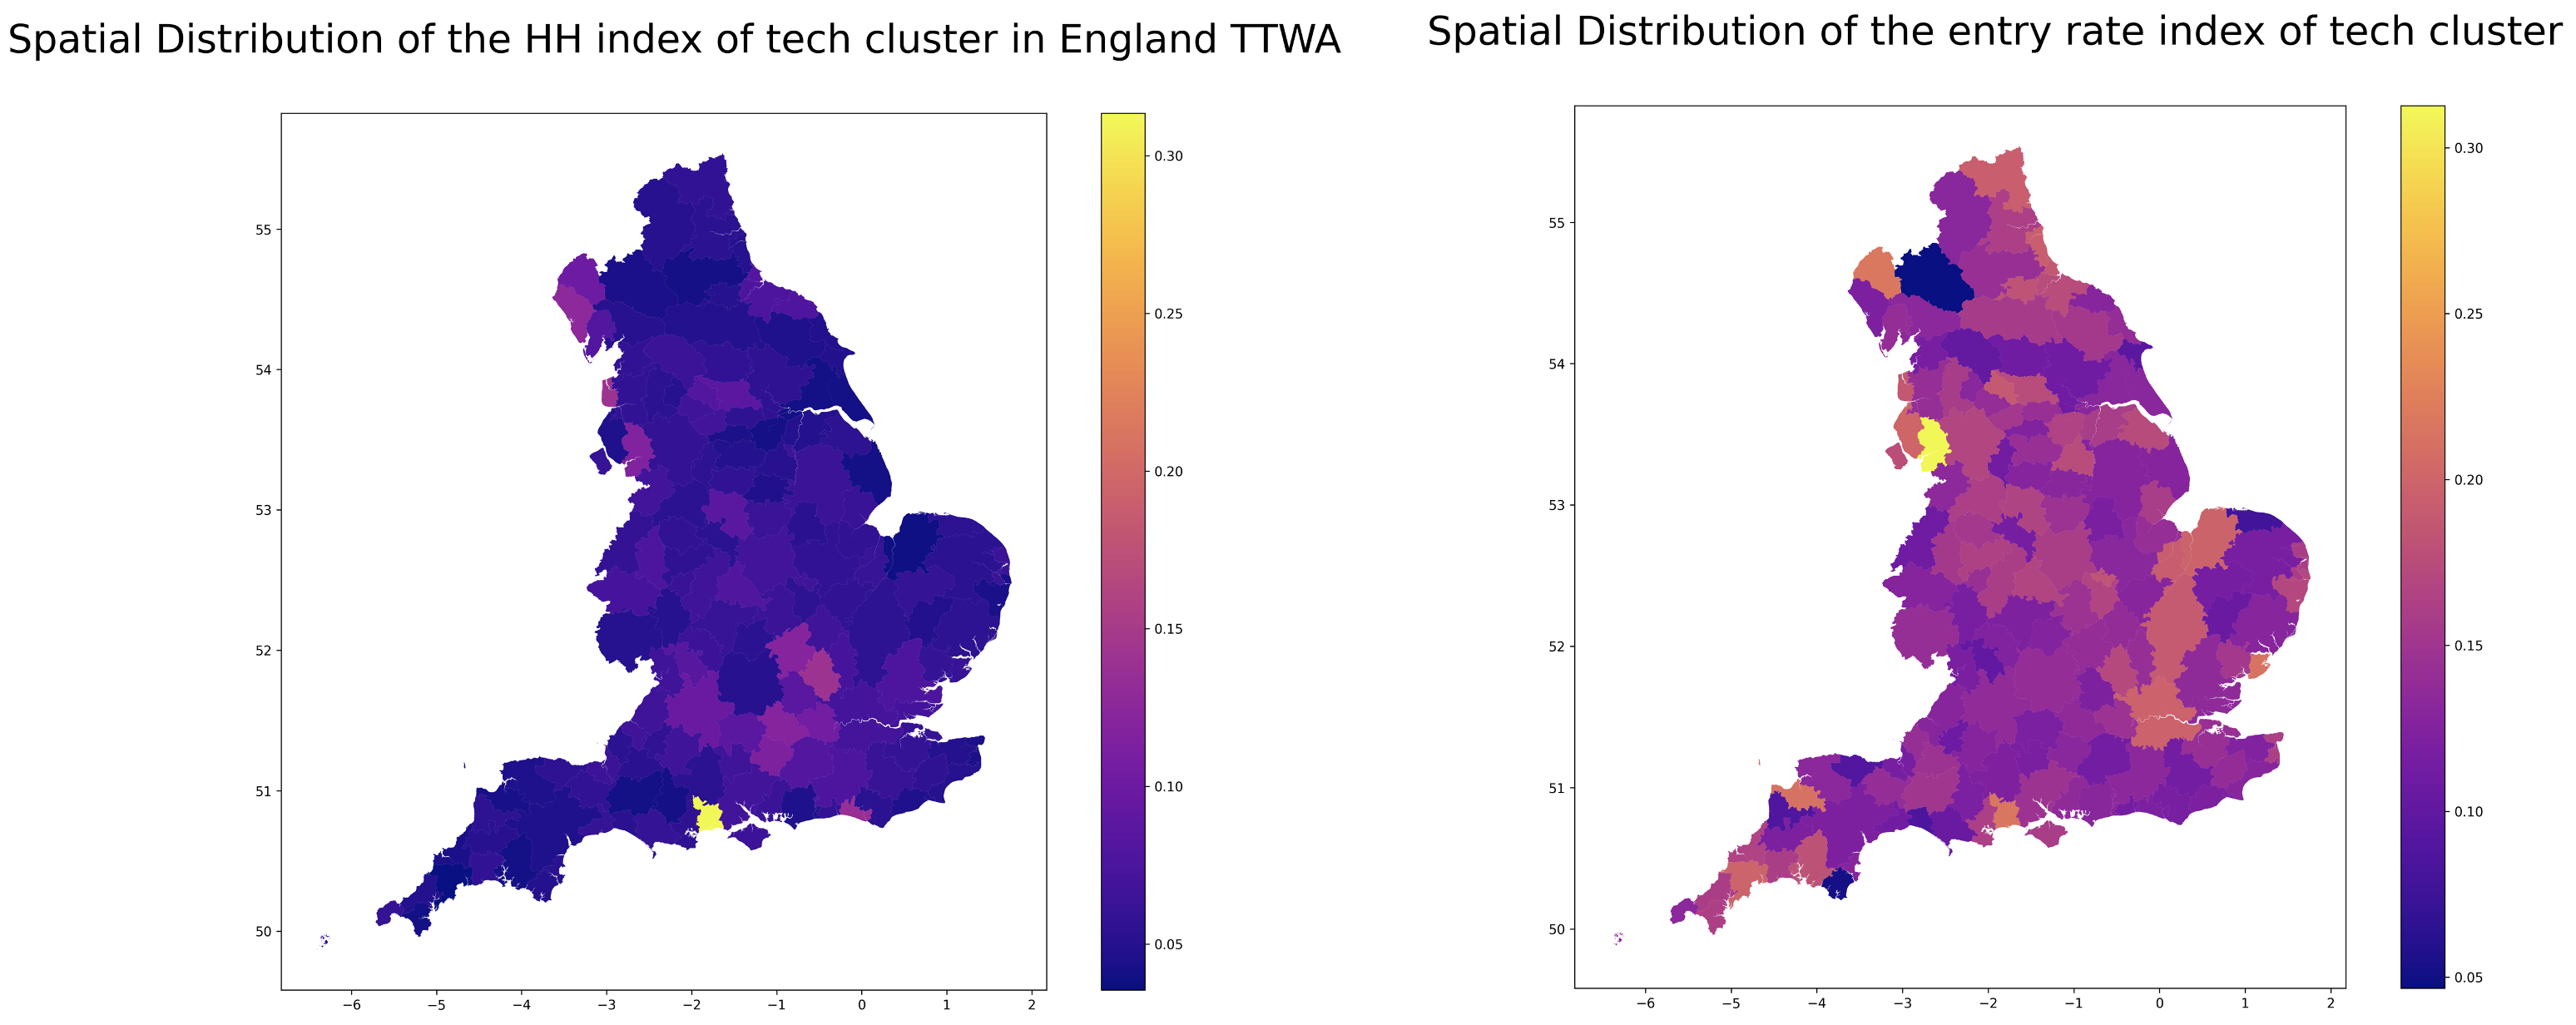

# Regression

1. Hypothesis
1. Data Prepare
1. Distribution EDA
1. OLS with std error
1. VIF
1. Regression
1. Residual

## Data Preparation

In [108]:
# the last dataset
import pandas as pd
import sys
PATH = sys.path[0]

df = pd.read_csv(PATH + "/Dataset/fame_OC_tech_firm.csv",low_memory=False)
df = df.drop({"Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1","is_tech"},axis = 1)

# preprocess the data
# drop the null value record in birth year and ttwa(travel to work area) columns
df = df.dropna(subset = {"birth_year","ttwa","latest_accounts_assets"})

# England's filter can be processed in the final stage with merge function
# filter by `birth_year`
# df_10_tc_20 means "top 10 tech ttwa clusters in 20 years dataframe"
df = df[df["birth_year"]>=1998].reset_index(drop=True)

# select data in below columns
df = df[["registered_number",\
        "ttwa",\
        "birth_year",\
        "diss_year",\
        "latest_accounts_assets"]]

df.head()
df_EnR_i_t = df.copy()
df_EnR_i_t.head()

,registered_number,ttwa,birth_year,diss_year,latest_accounts_assets
0,SC288343,S22000047,2005.0,NaN,1751549.0
1,SC216869,S22000047,2001.0,NaN,169943.0
2,SC257810,S22000047,2003.0,NaN,667169.0
3,SC410428,S22000047,2011.0,NaN,382800.0
4,SC293752,S22000047,2005.0,NaN,282765.0


In [109]:
# export to excel to process
df_EnR_i_t.to_excel(PATH + "/England_tech_cluster_ttwa_EnR_regPrepare.xlsx", index = False)

In [161]:
# after pivot operation
# read from excel
df_EnR_i_t = pd.read_excel(PATH + "/Excel/England_tech_cluster_ttwa_EnR_regPrepare.xlsx",sheet_name="England_ttwa_year_asset")

,ttwa,birth_year,firms,average_latest_accounts_assets,total,entry_rate
0,E30000004,"1,998.0000",4,"19,405.2500",509,0.0079
1,E30000004,"1,999.0000",6,"759,500.5000",509,0.0118
2,E30000004,"2,000.0000",6,"286,162.3333",509,0.0118
3,E30000004,"2,001.0000",7,"129,527.4286",509,0.0138
4,E30000004,"2,002.0000",10,"56,740.4000",509,0.0196


In [162]:
df_EnR_i_t = df_EnR_i_t.fillna(0)
df_EnR_i_t.birth_year = df_EnR_i_t.birth_year.astype(int)
df_EnR_i_t.head()

,ttwa,birth_year,firms,average_latest_accounts_assets,total,entry_rate
0,E30000004,1998,4,"19,405.2500",509,0.0079
1,E30000004,1999,6,"759,500.5000",509,0.0118
2,E30000004,2000,6,"286,162.3333",509,0.0118
3,E30000004,2001,7,"129,527.4286",509,0.0138
4,E30000004,2002,10,"56,740.4000",509,0.0196


In [170]:
df_left = df_EnR_i_t
left_key = ["ttwa","birth_year"]
print("Entry Rate Dataset is" + str(df_EnR_i_t.shape))

df_right = df_hh_i_t
right_key = ["ttwa","birth_year"]
print("HHI Dataset is" + str(df_hh_i_t.shape))

# merge
df_mg = pd.merge(df_left,df_right, left_on=left_key, right_on=right_key,how = "inner").reset_index(drop=True)

df_hh_EnR = df_mg.copy()
print("HHI&EnR Dataset is" + str(df_hh_EnR.shape))

df_hh_EnR.head()

Entry Rate Dataset is(4186, 6)
HHI Dataset is(3089, 3)
HHI&EnR Dataset is(2932, 7)


,ttwa,birth_year,firms,average_latest_accounts_assets,total,entry_rate,hh
0,E30000004,1998,4,"19,405.2500",509,0.0079,0.1200
1,E30000004,1999,6,"759,500.5000",509,0.0118,0.3333
2,E30000004,2000,6,"286,162.3333",509,0.0118,0.1562
3,E30000004,2001,7,"129,527.4286",509,0.0138,0.1250
4,E30000004,2002,10,"56,740.4000",509,0.0196,0.0909


In [179]:
df_ttwa = pd.read_csv(PATH + "/Dataset/ttwa.csv")
df_ttwa = df_ttwa[["code","name"]]

In [190]:
df_left = df_hh_EnR
left_key = "ttwa"
print("df_left is " + str(df_left.shape))

df_right = df_ttwa
right_key = "code"
print("df_right is " + str(df_right.shape))

# merge
df_mg = pd.merge(df_left,df_right, left_on=left_key, right_on=right_key,how = "inner").reset_index(drop=True)
print("df_merge" + str(df_mg.shape))

df_hh_EnR_ttwaName = df_mg.copy()

df_hh_EnR_ttwaName = df_hh_EnR_ttwaName[["name","code","birth_year","firms","total","entry_rate", "hh", "average_latest_accounts_assets"]]
df_hh_EnR_ttwaName = df_hh_EnR_ttwaName.rename({"name":"ttwa", "code":"ttwa_code", "birth_year":"year", "total":"total_firms"},axis=1)
df_hh_EnR_ttwaName.head()

df_left is (2932, 7)
df_right is (430, 2)
df_merge(2932, 9)


,ttwa,ttwa_code,year,firms,total_firms,entry_rate,hh,average_latest_accounts_assets
0,Barnsley,E30000004,1998,4,509,0.0079,0.1200,"19,405.2500"
1,Barnsley,E30000004,1999,6,509,0.0118,0.3333,"759,500.5000"
2,Barnsley,E30000004,2000,6,509,0.0118,0.1562,"286,162.3333"
3,Barnsley,E30000004,2001,7,509,0.0138,0.1250,"129,527.4286"
4,Barnsley,E30000004,2002,10,509,0.0196,0.0909,"56,740.4000"


## Distribution EDA

ref: https://blog.csdn.net/lys_828/article/details/104429073

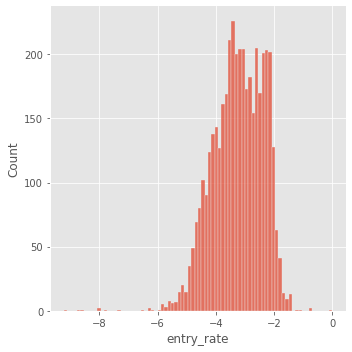

In [143]:
df = df_EnR_i_t.copy() # input your data
attributes = "entry_rate" # input your X

import seaborn as sns
import numpy as np
df[attributes] = np.log(df[attributes])
sns.displot(df, x=attributes,bins=80)

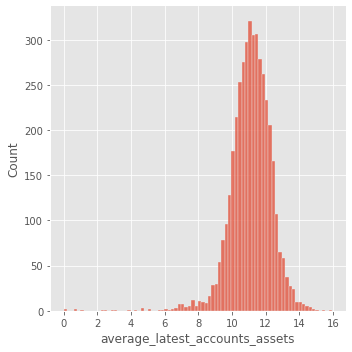

In [149]:
df = df_EnR_i_t.copy() # input your data
attributes = "average_latest_accounts_assets" # input your X

import seaborn as sns
import numpy as np
df[attributes] = np.log1p(df[attributes])
sns.displot(df, x=attributes,bins=80)

## Hypothesis

$\ Dynamics\ Variable_{i,t}\ =\ a_1 + b_1 \times firms_{i,t} + b_2 \times HHI_{i,t} + b_3 \times location_i + b_4 \times year_t$ (1)

$\ log_e\ {(Firm\ Performance_{i,t}+1)}\ =\ c_1 + d_1 \times firms_{i,t} + d_2 \times HHI_{i,t} + d_3 \times dynamics_{i,t} + d_4 \times location_i + d_5 \times year_t$ (2)

* $t$ means year -- `birth_year`
* $i$ means location -- `ttwa` (travel to work area)
* $Dynamics\ Variable_{i,t}$ in (1) means `Entry_Rate` in $t$ and $i$ 
* $dynamics_{i,t}$ in (2) means `Entry_Rate` in a specific $t$ and $i$ 
* $firms_{i,t}$ means `Count_of_tech_firms` in a specific $t$ and $i$
* $HHI_{i,t}$ means `Herfindahl-Hirschman Index` in a specific $t$ and $i$

## OLS with std error

In (1), Y is `entry_rate`, X is `ttwa`, `birth_year`, `total`, `hh`

In (2), Y is `average_latest_accounts_assets`, X is `ttwa`, `birth_year`, `total`, `hh`, `entry_rate`

In [137]:
# environment preparation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

introduce correlation analysis

Text(0.5, 1.0, 'Correlation Matrix')

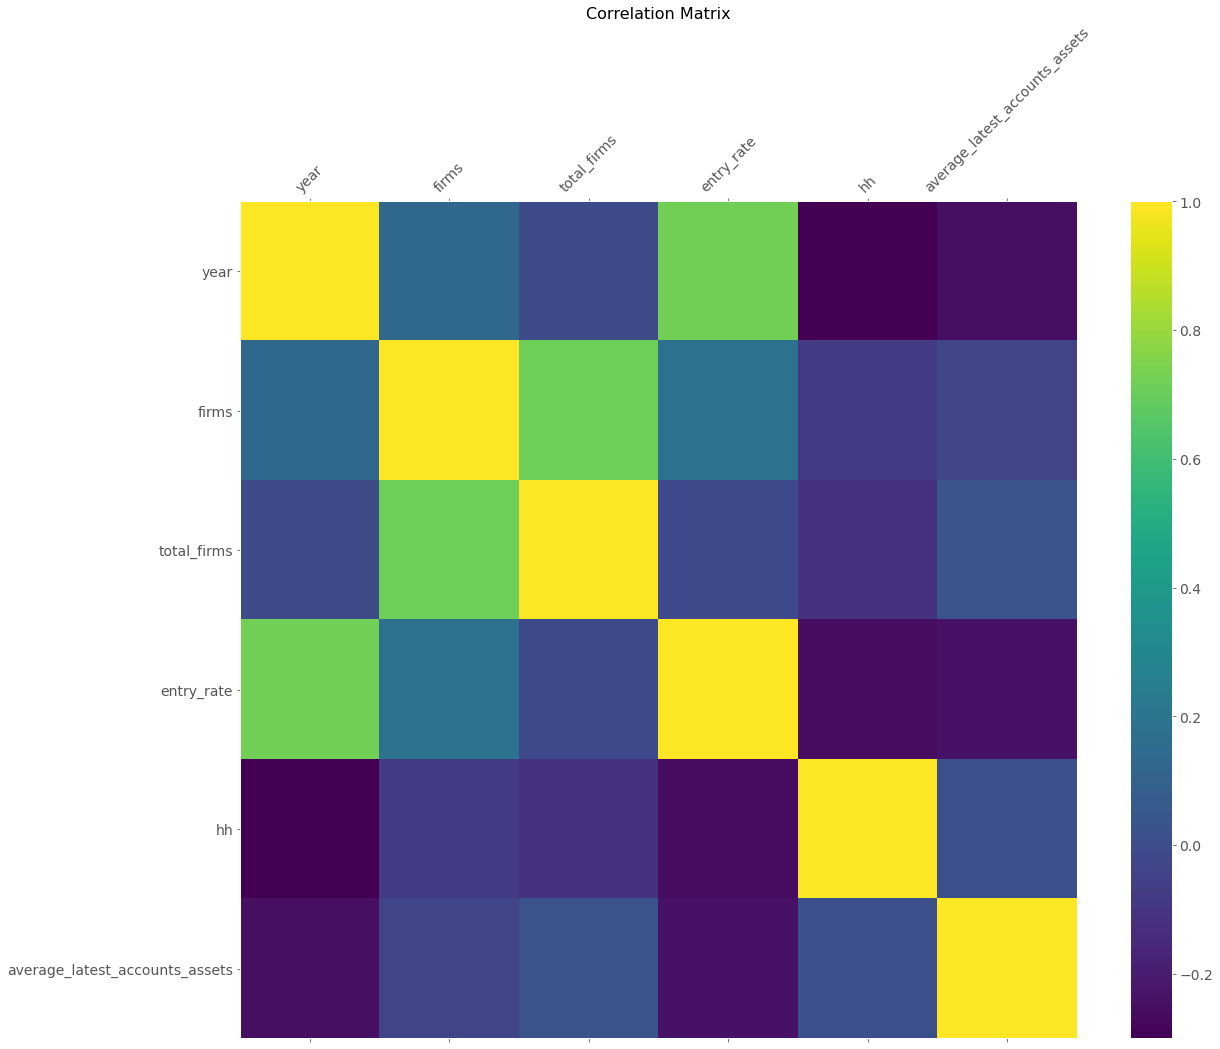

In [200]:
df = df_hh_EnR_ttwaName.copy()

df.year = df.year.astype("int")
df = df.drop({"ttwa","ttwa_code"},axis=1)

# add dummies operation requirement 
# Set the reference object is ttwa_E30000234（London）
# drop Birmingham for dummies variables comparasion
# df = df.drop(['ttwa_London'], axis=1)

# correlation analysis
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# df = pd.get_dummies(df)

introduce the dummy variables

In [ ]:
df = df_hh_EnR_ttwaName.copy()

# intro dummy variables
df.year = df.year.astype("int")
df = df.drop({"ttwa_code"},axis=1)
df = pd.get_dummies(df)

# add dummies operation requirement 
# Set the reference object is ttwa_E30000234（London）
# drop Birmingham for dummies variables comparasion
df = df.drop(['ttwa_London'], axis=1)

# gd means get dummies
df_hh_EnR_gd = df.copy()

### VIF

In [219]:
# VIF method
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const').drop(list_var_not_to_remove)
        
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

### All Tech Firms in England (OLS)

In (1):

$\ {Dynamics\ Variable_{i,t}}^{0.5}\ =\ a_1 + b_1 \times firms_{i,t} + b_2 \times HHI_{i,t} + b_3 \times location_i + b_4 \times year_t$

In [ ]:
predictors_X = df_hh_EnR_gd.drop({'entry_rate','average_latest_accounts_assets'}, axis=1) # drop the Y_1 and Y_2
response_Y = df_hh_EnR_gd['entry_rate']
list_var_not_to_remove = ["year","firms","hh"] # this is a list of dummy variables that represent a categorical variable with three or more categories. They should not be removed even if it has a high VIF. 

df_predictors_select_VIF = drop_column_using_vif_(predictors_X, list_var_not_to_remove, thresh=5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

regressor_OLS = sm.OLS(endog=response_Y, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

In (2):

$\ log_e\ {(Firm\ Performance_{i,t}+1)}\ =\ c_1 + d_1 \times firms_{i,t} + d_2 \times HHI_{i,t} + d_3 \times dynamics_{i,t} + d_4 \times location_i + d_5 \times year_t$ (2)

In [ ]:
predictors_X = df_hh_EnR_gd.drop({'average_latest_accounts_assets'}, axis=1) # drop the Y_1 and Y_2
response_Y = df_hh_EnR_gd['average_latest_accounts_assets']
list_var_not_to_remove = ["entry_rate","year","firms","hh"] # this is a list of dummy variables that represent a categorical variable with three or more categories. They should not be removed even if it has a high VIF. 

df_predictors_select_VIF = drop_column_using_vif_(predictors_X, list_var_not_to_remove, thresh=5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

regressor_OLS = sm.OLS(endog=response_Y, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

### Top 10 Tech Cluster (OLS)

small data preparation

In [243]:
df = pd.read_csv(PATH + "/Dataset/fame_OC_tech_firm.csv",low_memory=False)
df = df.drop({"Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1","is_tech"},axis = 1)
df = df.dropna(subset = {"birth_year","ttwa"})

# Generate the top 10 tech clusters table based on the ttwa
top_10_ttwa = df.ttwa.value_counts().head(10)
top_10_ttwa = pd.DataFrame(top_10_ttwa).reset_index()
top_10_ttwa.columns = ["ttwa_code","counts"]

In [245]:
df_ttwa = pd.read_csv(PATH + "/Dataset/ttwa.csv")
df_ttwa = pd.merge(top_10_ttwa, df_ttwa[["code","name"]], left_on="ttwa_code",right_on="code")
df_ttwa_10 = df_ttwa[["ttwa_code", "name","counts"]]

# df_10_tc means "top 10 tech ttwa clusters"
df_10_tc = df_hh_EnR_ttwaName.copy()
# filter data to top 10 ttwa data raws
df_10_tc = df_10_tc[df_10_tc.ttwa_code.isin(df_ttwa_10.ttwa_code.to_list())].reset_index(drop=True)

df_10_tc = df_10_tc.drop({"ttwa_code"},axis=1)
# get dummies
df_10_tc = pd.get_dummies(df_10_tc)
df_10_tc = df_10_tc.drop({"ttwa_London"},axis=1)

In (1):

$\ Dynamics\ Variable_{i,t}\ =\ a_1 + b_1 \times firms_{i,t} + b_2 \times HHI_{i,t} + b_3 \times location_i + b_4 \times year_t$

In [288]:
df = df_10_tc.copy()

predictors_X = df.drop({'entry_rate','average_latest_accounts_assets'}, axis=1) # drop the Y_1 and Y_2
response_Y = np.sqrt(df['entry_rate'])
list_var_not_to_remove = ["year","firms","hh"] # this is a list of dummy variables that represent a categorical variable with three or more categories. They should not be removed even if it has a high VIF. 

df_predictors_select_VIF = drop_column_using_vif_(predictors_X, list_var_not_to_remove, thresh=5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

regressor_OLS = sm.OLS(endog=response_Y, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

Max VIF: inf
Dropping: total_firms
Max VIF: 3.7134254005603826
The columns remaining after VIF selection are:
Index(['year', 'firms', 'hh', 'ttwa_Birmingham', 'ttwa_Bournemouth',
       'ttwa_Brighton', 'ttwa_Bristol', 'ttwa_Cambridge',
       'ttwa_Guildford and Aldershot', 'ttwa_Luton', 'ttwa_Manchester',
       'ttwa_Slough and Heathrow'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             entry_rate   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     38.95
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           8.55e-45
Time:                        18:06:52   Log-Likelihood:                 314.46
No. Observations:                 203   AIC:                            -602.9
Df Residuals:                     190   BIC:                            -559.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -19.0665      1.448    -13.169      0.000     -21.922     -16.211
year                             0.0095      0.001     13.159      0.000       0.008       0.011
firms                         3.013e-05   4.23e-06      7.131      0.000    2.18e-05    3.85e-05
hh                               0.4612      0.096      4.794      0.000       0.271       0.651
ttwa_Birmingham                  0.0958      0.020      4.766      0.000       0.056       0.135
ttwa_Bournemouth                 0.0212      0.024      0.880      0.380      -0.026       0.069
ttwa_Brighton                    0.0513      0.021      2.474      0.014       0.010       0.092
ttwa_Bristol                     0.1014      0.020      4.985      0.000       0.061       0.142
ttwa_Cambridge                   0.1079      0.020      5.302      0.000       0.068       0.148
ttwa_Guildford and Aldershot     0.0982      0.020      4.790      0.000       0.058       0.139
ttwa_Luton                       0.0643      0.021      3.006      0.003       0.022       0.107
ttwa_Manchester                  0.0801      0.020      4.105      0.000       0.042       0.119
ttwa_Slough and Heathrow         0.0762      0.020      3.845      0.000       0.037       0.115
==============================================================================
Omnibus:                       94.115   Durbin-Watson:                   1.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              508.515
Skew:                          -1.722   Prob(JB):                    3.78e-111
Kurtosis:                       9.947   Cond. No.                     8.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

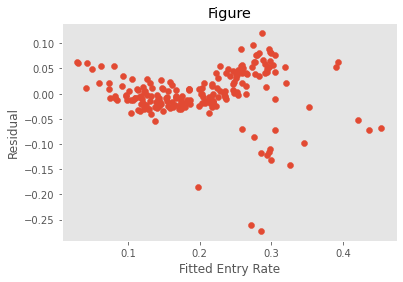

In [289]:
plt.scatter(regressor_OLS.fittedvalues, regressor_OLS.resid)
# adding title and labels
plt.xlabel('Fitted Entry Rate')
plt.ylabel('Residual')
plt.title('Figure')
#plt.ylim(-1,1)
plt.show()

In (2):

$\ log_e\ {(Firm\ Performance_{i,t}+1)}\ =\ c_1 + d_1 \times firms_{i,t} + d_2 \times HHI_{i,t} + d_3 \times dynamics_{i,t} + d_4 \times location_i + d_5 \times year_t$ (2)

In [259]:
df = df_10_tc.copy()
df.average_latest_accounts_assets = np.log1p(df.average_latest_accounts_assets)

predictors_X = df.drop({'average_latest_accounts_assets'}, axis=1) # drop the Y_1 and Y_2
response_Y = df['average_latest_accounts_assets']
list_var_not_to_remove = ["entry_rate","year","firms","hh"] # this is a list of dummy variables that represent a categorical variable with three or more categories. They should not be removed even if it has a high VIF. 

df_predictors_select_VIF = drop_column_using_vif_(predictors_X, list_var_not_to_remove, thresh=5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

regressor_OLS = sm.OLS(endog=response_Y, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

Max VIF: inf
Dropping: total_firms
Max VIF: 3.7368565027151392
The columns remaining after VIF selection are:
Index(['year', 'firms', 'entry_rate', 'hh', 'ttwa_Birmingham',
       'ttwa_Bournemouth', 'ttwa_Brighton', 'ttwa_Bristol', 'ttwa_Cambridge',
       'ttwa_Guildford and Aldershot', 'ttwa_Luton', 'ttwa_Manchester',
       'ttwa_Slough and Heathrow'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     average_latest_accounts_assets   R-squared:                       0.691
Model:                                        OLS   Adj. R-squared:                  0.670
Method:                             Least Squares   F-statistic:                     32.57
Date:                            Sun, 01 Aug 2021   Prob (F-statistic):           2.32e-41
Time:                                    17:49:25   Log-Likelihood:                -119.36
No. Observations:                             203   AIC:                             266.7
Df Residuals:                                 189   BIC:                             313.1
Df Model:                                      13                                         
Covariance Type:                        nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          227.3039     16.355     13.898      0.000     195.042     259.566
year                            -0.1072      0.008    -13.133      0.000      -0.123      -0.091
firms                         -2.19e-05   4.05e-05     -0.541      0.589      -0.000     5.8e-05
entry_rate                       0.5869      1.297      0.452      0.652      -1.972       3.146
hh                               0.0250      0.875      0.029      0.977      -1.700       1.750
ttwa_Birmingham                 -0.6028      0.180     -3.357      0.001      -0.957      -0.249
ttwa_Bournemouth                -0.8281      0.206     -4.029      0.000      -1.234      -0.423
ttwa_Brighton                   -0.8439      0.180     -4.701      0.000      -1.198      -0.490
ttwa_Bristol                    -0.5729      0.182     -3.154      0.002      -0.931      -0.215
ttwa_Cambridge                  -0.4758      0.183     -2.605      0.010      -0.836      -0.115
ttwa_Guildford and Aldershot    -0.4033      0.182     -2.221      0.028      -0.761      -0.045
ttwa_Luton                      -0.5280      0.185     -2.854      0.005      -0.893      -0.163
ttwa_Manchester                 -0.6243      0.173     -3.613      0.000      -0.965      -0.283
ttwa_Slough and Heathrow        -0.4768      0.174     -2.747      0.007      -0.819      -0.134
==============================================================================
Omnibus:                       97.917   Durbin-Watson:                   1.601
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2761.319
Skew:                          -1.178   Prob(JB):                         0.00
Kurtosis:                      20.914   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

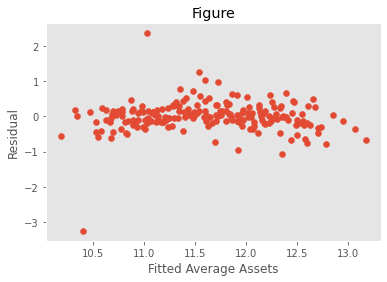

In [260]:
plt.scatter(regressor_OLS.fittedvalues, regressor_OLS.resid)
# adding title and labels
plt.xlabel('Fitted Average Assets')
plt.ylabel('Residual')
plt.title('Figure')
# plt.ylim(-0.5,0.5)
plt.show()

# Moran'I and GWR

In [326]:
# value include dynamics, industry mix and firms' performance
df1 = df_hh_EnR_ttwaName.copy()
df1.shape

(2932, 8)

In [328]:
df1.describe()

,year,firms,total_firms,entry_rate,hh,average_latest_accounts_assets
count,"2,932.0000","2,932.0000","2,932.0000","2,932.0000","2,932.0000","2,932.0000"
mean,"2,007.6388",75.9778,"1,548.4679",0.0508,0.1529,"133,348.4642"
std,5.7655,363.9759,"5,430.8692",0.0377,0.1586,"256,480.0257"
min,"1,998.0000",1.0000,37.0000,0.0001,0.0397,0.0000
25%,"2,003.0000",8.0000,205.0000,0.0209,0.0746,"41,155.3538"
50%,"2,008.0000",21.0000,517.0000,0.0392,0.1016,"79,520.2717"
75%,"2,013.0000",55.0000,"1,335.0000",0.0763,0.1578,"155,195.6270"
max,"2,018.0000","9,282.0000","62,757.0000",0.2082,1.0000,"8,532,989.0000"


In [331]:
df1[df1.hh == 1].ttwa.unique()

array(['Skipton', 'Hexham and Haltwhistle', 'Minehead',
       'Penrith and Appleby', 'Whitby', 'Barrow-in-Furness', 'Bideford',
       'Boston', 'Bridgwater', 'Bridlington', 'Bridport', 'Bude',
       'Buxton', 'Clacton', 'Cromer and Sheringham', 'Darlington',
       'Great Yarmouth', 'Hartlepool', 'Kingsbridge and Dartmouth',
       'Launceston', 'Liskeard', 'Lowestoft', 'Ludlow', 'Penzance',
       'Scarborough', 'Scunthorpe', 'Skegness and Louth', 'Wadebridge',
       'Whitehaven', 'Wisbech', 'Workington'], dtype=object)

export df1 to MySQL to operate

In [327]:
df1.to_csv(PATH + "/MySQL/df_hh_EnR_ttwaName.csv")

MySQL operation ...

```mysql
DROP TABLE IF EXISTS tech_cluster_hh_enr_ttwa_for_r;
CREATE TABLE tech_cluster_hh_enr_ttwa_for_r
SELECT * FROM (select    t1.ttwa
                        ,t1.ttwa_code
                        ,sum(t1.firms) as entry_total
                        ,avg(t1.total_firms) as grand_total
                        ,avg(t1.hh) as hhi
                        ,avg(t1.entry_rate) as entry_rate
                        ,avg(t1.average_latest_accounts_assets) as assets
                        from `casa-dissertation`.df_hh_enr_for_r as t1
                        group by t1.ttwa) as t2
```

read `df1` from MySQL

In [343]:
df1 = pd.read_csv(PATH + "/MySQL/tech_cluster_hh_enr_ttwa_for_r.csv",",")

In [344]:
type(g_ttwa_England)
type(df1)

pandas.core.frame.DataFrame

In [345]:
df_left = g_ttwa_England
left_key = 'TTWA11CD'

df_right = df1
right_key = "ttwa_code"

# merge
df_mg = pd.merge(df_left,df_right, left_on = left_key,right_on=right_key,how = "inner").reset_index(drop=True)
type(df_mg)

geopandas.geodataframe.GeoDataFrame

In [346]:
df_mg.shape

(149, 13)

In [347]:
# df_mg.to_csv(PATH + "/HHI_EnR_ttwa_England_for_R.csv")
import geopandas as gpd
import fiona

# export the geojson
df_mg.to_file(PATH + "/Dataset/Spatial/HHI_EnR_ttwa_England_for_R.geojson", driver='GeoJSON')